<a href="https://colab.research.google.com/github/afortuny/DeepLearningFastAI/blob/main/14_Convolutions%20Deep%20Dive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

## Kernels and Convolutions

In this notebook we will dig into what convolutions are and building a CNN from scratch. We will then study a range of techniques to improve training stability and learn all the tweaks the library usually applies for us to get great results

One of the first features that image models try to get is edges on an image. It turns out that finding the edges in an image is a very common task in computer vision, and is surprisingly straightforward. To do it, we use something called a convolution. A convolution requires nothing more than multiplication, and addition—two operations that are responsible for the vast majority of work that we will see in every single deep learning model. A convolution applies a kernel (little matrix) across an image. 

In [3]:
top_edge = tensor([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]]).float()

In [4]:
path = untar_data(URLs.MNIST_SAMPLE)

In [5]:
#hide
Path.BASE_PATH = path

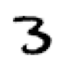

In [6]:
im3 = Image.open(path/'train'/'3'/'12.png')
show_image(im3);

In [9]:
im3_t = tensor(im3)

Let's create a function to apply the top edge kernel over a part of the image and sum the results of it

In [7]:
def apply_kernel(row, col, kernel):
    return (im3_t[row-1:row+2,col-1:col+2] * kernel).sum()

In [11]:
#hide_output
df = pd.DataFrame(im3_t[:10,:20])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0
6,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0
7,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0
8,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0


We can see that the resulting tensor after applying the kernel will provide a high value for 5,7 but a small onefor 9,8.

In [10]:
apply_kernel(5,7,top_edge)

tensor(762.)

In [16]:
apply_kernel(9,8,top_edge)

tensor(-25.)

We can apply the kernel over the whole image and visualize the output, where the horizontal edges are remarked:

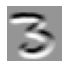

In [17]:
rng = range(1,27)
top_edge3 = tensor([[apply_kernel(i,j,top_edge) for j in rng] for i in rng])

show_image(top_edge3);

## Convolutions in Pytorch

Convolution is such an important and widely used operation that PyTorch has it built in. It's called F.conv2d (recall that F is a fastai import from torch.nn.functional, as recommended by PyTorch). The PyTorch docs tell us that it includes these parameters:


*   input:: input tensor of shape (minibatch, in_channels, iH, iW)
*   weight:: filters of shape (out_channels, in_channels, kH, kW)


Here iH,iW is the height and width of the image (i.e., 28,28), and kH,kW is the height and width of our kernel (3,3). But apparently PyTorch is expecting rank-4 tensors for both these arguments, whereas currently we only have rank-2 tensors (i.e., matrices, or arrays with two axes).

The reason for these extra axes is that PyTorch has a few tricks up its sleeve. The first trick is that PyTorch can apply a convolution to multiple images at the same time. That means we can call it on every item in a batch at once!

The second trick is that PyTorch can apply multiple kernels at the same time. So let's create the diagonal-edge kernels too, and then stack all four of our edge kernels into a single tensor:

In [30]:
diag1_edge = tensor([[ 0,-1, 1],
                     [-1, 1, 0],
                     [ 1, 0, 0]]).float()
diag2_edge = tensor([[ 1,-1, 0],
                     [ 0, 1,-1],
                     [ 0, 0, 1]]).float()
left_edge = tensor([[-1,1,0],
                    [-1,1,0],
                    [-1,1,0]]).float()
edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])
edge_kernels.shape

torch.Size([4, 3, 3])

In [20]:
mnist = DataBlock((ImageBlock(cls=PILImageBW), CategoryBlock), 
                  get_items=get_image_files, 
                  splitter=GrandparentSplitter(),
                  get_y=parent_label)

dls = mnist.dataloaders(path)
xb,yb = first(dls.valid)
xb.shape

torch.Size([64, 1, 28, 28])

One batch contains 64 images, each of 1 channel, with 28×28 pixels. F.conv2d can handle multichannel (i.e., color) images too. A channel is a single basic color in an image—for regular full-color images there are three channels, red, green, and blue. PyTorch represents an image as a rank-3 tensor, with dimensions [channels, rows, columns].

We'll see how to handle more than one channel later in this chapter. Kernels passed to F.conv2d need to be rank-4 tensors: [channels_in, features_out, rows, columns]. edge_kernels is currently missing one of these. We need to tell PyTorch that the number of input channels in the kernel is one, which we can do by inserting an axis of size one (this is known as a unit axis) in the first location, where the PyTorch docs show in_channels is expected. To insert a unit axis into a tensor, we use the unsqueeze method:

In [31]:
edge_kernels = edge_kernels.unsqueeze(1)

In [32]:
edge_kernels.shape

torch.Size([4, 1, 3, 3])

In [33]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([64, 4, 26, 26])

The output shape shows we gave 64 images in the mini-batch, 4 kernels, and 26×26 edge maps (we started with 28×28 images, but lost one pixel from each side). We can see we get the same results as when we did this manually:

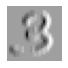

In [34]:
show_image(batch_features[0,0]);

It would be nice to not lose those two pixels on each axis. The way we do that is to add padding, which is simply additional pixels added around the outside of our image. Most commonly, pixels of zeros are added.

## Padding

With appropriate padding, we can ensure that the output activation map is the same size as the original image, which can make things a lot simpler when we construct our architecture. For example, 2ith a 5×5 input, 4×4 kernel, and 2 pixels of padding, we end up with a 6×6 activation map.

So far, when we have applied the kernel to the grid, we have moved it one pixel over at a time. But we can jump further; for instance, we could move over two pixels after each kernel application. This is known as a stride-2 convolution. The most common kernel size in practice is 3×3, and the most common padding is 1. As you'll see, stride-2 convolutions are useful for decreasing the size of our outputs, and stride-1 convolutions are useful for adding layers without changing the output size.

In an image of size h by w, using a padding of 1 and a stride of 2 will give us a result of size (h+1)//2 by (w+1)//2. The general formula for each dimension is:

*   (n + 2*pad - ks)//stride + 1
   

Where pad is the padding, ks, the size of our kernel, and stride is the stride.

In [35]:
(28+2*1-3)/(2+1) #for a 28x28 input with padding of 1, 3x3 kernel size and stride 2 we will go down to 9x9 output

9.0